In [3]:
#!pip install stable-baselines3[extra] gym joblib seaborn torchviz
import joblib
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.linear_model import SGDRegressor
import os
import gym
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
import seaborn as sns
import pandas as pd
import time
import copy
import torch
import torch.nn as nn
import itertools
import torch.optim as optim
import math

/home/bunzelh/miniconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class AIzyme_simulator(gym.Env):
    """
    Custom Environment that follows gym interface.
    This environment simulates the optimization of two scores (interface_score and total_score)
    with actions Run_Active_Site_Rosetta_Design and Run_Protein_MPNN.
    The scores start from 1 and can go up to infinity, with higher scores being better.
    The random effect on each score is a function of the previous reward.
    """
    metadata = {'render.modes': ['console']}

    def __init__(self):
        super(AIzyme_simulator, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=np.array([1, 1]),  
                                            high=np.array([np.inf, np.inf]),
                                            dtype=np.float32)

    def reset(self):
        self.state = np.array([1, 1], dtype=np.float32)  # [0, 0] for no previous action
        self.combined_score = 1  # Initialize the reward
        self.reward         = 0  # Initialize the reward
        return self.state, self.action_space.n, self.observation_space.shape[0]

    def step(self, action, state):
        interface_score, total_score = self.state

        # Define the improvement function
        def improvement_function(score_1, score_2, action):
            if action == 0:
                score_1 += np.random.normal(5.0, 0.2)/(score_1+1) ### give advantage to rosetta
            if action == 1:
                score_1 += np.random.normal(1.0, 0.2)/(score_1+1) ### give disadvantage to mpnn
            score_2 += np.random.normal(0.0, 0.1)/(score_2+1)
            return(score_1,score_2)
        
        if action == 0:  # Run_Active_Site_Rosetta_Design
            interface_score, total_score = improvement_function(interface_score, total_score, action)
        if action == 1:  # Run_Protein_MPNN
            total_score, interface_score = improvement_function(total_score, interface_score, action)
        if interface_score < 0: interface_score = 0
        if total_score < 0: total_score = 0         
     
        # Update reward, combined_score, and state
        combined_score = (total_score*interface_score)**0.5
        self.reward = combined_score - self.combined_score
        self.combined_score = combined_score
        
        self.state = np.array([interface_score, total_score])
       
        done = False
        info = {}

        return self.state, self.reward, done, info

    def render(self, mode='console'):
        if mode != 'console':
            raise NotImplementedError()
        print(f"Total Score: {self.state[0]}, Interface Score: {self.state[1]}")

    def close(self):
        pass
    
    def load_state(self, model_directory):
        try:
            self.state = np.load(f'{model_directory}/state.npy')
            return self.state, self.action_space.n, self.observation_space.shape[0]
        except FileNotFoundError:
            self.state = self.reset()
            return self.state, self.action_space.n, self.observation_space.shape[0]

In [10]:
class NeuralBanditModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        
        super(NeuralBanditModel, self).__init__()
        
        hidden_size = 2 ** (input_size) - 1
        #hidden_size = math.factorial(input_size)
        
        self.fc1  = nn.Linear(input_size, hidden_size)
        self.fc2  = nn.Linear(hidden_size, hidden_size)
        self.fc3  = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

class NeuralBanditAgent:
    def __init__(self, n_actions, n_features, hidden_size=3, epsilon_0=0.9, epsilon_1=0.1, epsilon_decay=0.995, lr=0.01):
        self.n_actions = n_actions
        self.model = NeuralBanditModel(n_features, hidden_size, n_actions)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.action_counts = np.zeros(n_actions, dtype=int)
        self.rewards = []
        self.states = []
        self.norm_rewards = []
        self.norm_states = []
        self.actions_taken = []
        self.loss = []
        self.predecessors = []
        self.normalization    = {'interface_scores':[0,0],'total_scores':[0,0]}  
        self.epsilon_0 = epsilon_0
        self.epsilon_1 = epsilon_1
        self.epsilon_decay = epsilon_decay
        self.fitting_times = []
        self.RMSE_weights = []
        self.initial_model_state = copy.deepcopy([param.data.numpy() for param in self.model.parameters()])
        self.initial_model_state = np.concatenate([arr.flatten() for arr in self.initial_model_state])

    def select_action(self, state):
        if random.random() < self.epsilon_0 + self.epsilon_1:
            return random.randint(0, self.n_actions - 1)  # Random action
        else:
            state_tensor = torch.FloatTensor(state)
            predicted_rewards = self.model(state_tensor)
            return torch.argmax(predicted_rewards).item()

    def normalize(self):
               
        self.norm_states  = [[j for j in i] for i in self.states]
        self.norm_rewards = [i for i in self.rewards]
                
        def norm(val, norm):
            #if norm[1] != 0.0:
            #    return ((val-norm[0])/norm[1])
            #else:
            #    return 0
            return val/norm[0]
        
        for idx in range(len(self.states)):  
          
            self.norm_states[idx][0] = norm(self.norm_states[idx][0], self.normalization['interface_scores'])
            self.norm_states[idx][1] = norm(self.norm_states[idx][1], self.normalization['total_scores'])
            
            norm_reward = (self.norm_states[idx][0] * self.norm_states[idx][1])**0.5
            predecessor = idx - 1
            self.norm_rewards[idx] = norm_reward - self.norm_rewards[predecessor]
            
            if idx == 0: continue

    def reinitialize_weights(self, model):
        #Reinitializes the weights of a given model.
        if isinstance(model, nn.Linear):
            model.reset_parameters()
        elif hasattr(model, 'children'):
            for child in model.children():
                self.reinitialize_weights(child)
        
    def update_model(self, action, state, reward, episode, batch_fit_episode = np.inf):
        
        self.rewards.append(reward)
        self.states.append(state)
        self.actions_taken.append(action)
        self.epsilon_0 *= self.epsilon_decay
        
        start_time = time.time()  # Start time

        #Only update normalization factors while batch fitting
        if episode < batch_fit_episode:
            self.normalization['interface_scores'] = [np.average(self.states,axis=0)[0]]
            self.normalization['total_scores']     = [np.average(self.states,axis=0)[1]]
        
        #Normalization
        self.normalize()
        
        # Convert to tensors
        state_tensor = torch.FloatTensor(self.norm_states)

        # Prepare the reward tensor for the chosen action
        if episode < batch_fit_episode:
            # For batch fitting, create a reward tensor with rewards only for the chosen actions
            reward_tensor = torch.zeros(len(self.norm_rewards), self.n_actions)
            for i, r in enumerate(self.norm_rewards):
                reward_tensor[i, self.actions_taken[i]] = r
        else:
            # For incremental fitting, only consider the most recent action and reward
            reward_tensor = torch.zeros(1, self.n_actions)
            reward_tensor[0, action] = self.norm_rewards[-1]

        # Predict the reward and calculate loss
        predicted_rewards = self.model(state_tensor)
        criterion = nn.MSELoss()

        # Calculate loss only for the chosen action
        action_indices = torch.tensor(self.actions_taken, dtype=torch.long)
        predicted_rewards_for_chosen_actions = predicted_rewards[torch.arange(len(predicted_rewards)), action_indices]
        loss = criterion(predicted_rewards_for_chosen_actions, torch.FloatTensor(self.norm_rewards))
        self.loss.append(loss.item())

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        current_model_state = [param.data.numpy() for param in self.model.parameters()]
        current_model_state = np.concatenate([arr.flatten() for arr in current_model_state])
        
        squared_diff = (current_model_state - self.initial_model_state)**2 # Element-wise subtraction and squaring
        rmse         = np.sqrt(np.mean(squared_diff))                      # Mean and square root of differences    
        self.RMSE_weights.append(rmse)
    
        end_time = time.time()
        self.fitting_times.append(end_time - start_time)
        
    def plot(self):

        interface_scores = [i[0] for i in self.norm_states]
        total_scores     = [i[1] for i in self.norm_states]
                                
        # Creating the 2x2 plot
        fig, axs = plt.subplots(2, 3, figsize=(10, 6))

        # Reward and Loss
        cumulative_rewards = np.cumsum(self.rewards[1:])
        cumulative_loss    = np.cumsum(self.loss[1:])
        cumulative_rewards /= np.amax(cumulative_rewards)
        cumulative_loss    /= np.amax(cumulative_loss)
        
        axs[0, 0].plot(range(len(cumulative_loss)), cumulative_loss, label='Cumulative Loss')
        axs[0, 0].plot(range(len(cumulative_rewards)), cumulative_rewards, label='Cumulative Rewards')
        axs[0, 0].set_xlabel('Episodes')
        axs[0, 0].set_ylabel('Reward or Loss')
        axs[0, 0].set_title('Reward or Loss Over Episodes')
        axs[0, 0].set_xlim(0, len(cumulative_loss))
        axs[0, 0].set_ylim(0,1)
        axs[0, 0].legend()

        # All three scores vs. episodes
        axs[0, 1].plot(range(len(total_scores)), total_scores, label='Total Score')
        axs[0, 1].plot(range(len(interface_scores)), interface_scores, label='Interface Score')
        axs[0, 1].set_xlabel('Episodes')
        axs[0, 1].set_ylabel('Scores')
        axs[0, 1].set_title('Scores Over Episodes')
        axs[0, 1].set_xlim(0, len(total_scores))
        axs[0, 1].set_ylim(ymin=0)
        axs[0, 1].legend()

        axs[0, 2].plot(range(len(self.fitting_times)), self.fitting_times)
        axs[0, 2].set_title("Fitting Times")
        axs[0, 2].set_ylabel("Time (seconds)")
        axs[0, 2].set_xlim(0, len(self.fitting_times))
        axs[0, 2].set_ylim(ymin=0)
    
        # Scatter plot of Interface Score vs. Total Score
        scatter = axs[1, 0].scatter(total_scores, interface_scores, c=self.actions_taken, cmap='viridis')
        lim = np.amax(total_scores + interface_scores)
        axs[1, 0].set_xlim(0,lim)
        axs[1, 0].set_ylim(0,lim)
        axs[1, 0].plot(axs[1, 0].get_xlim(), axs[1, 0].get_ylim(), ls="--", c=".3")
        axs[1, 0].set_xlabel('Total Score')
        axs[1, 0].set_ylabel('Interface Score')
        axs[1, 0].set_title('Interface Score vs. Total Score')

        # change of model over optimization
        axs[1, 1].plot(range(len(self.RMSE_weights)), self.RMSE_weights)
        axs[1, 1].set_xlim(0, len(self.RMSE_weights))
        #axs[1, 1].set_yscale("log")  
        axs[1, 1].set_xlabel('Episodes')
        axs[1, 1].set_ylabel('RMSE')
        axs[1, 1].set_title('RMSE of Weights compared to initial model')

        percent = float(sum(self.actions_taken))/len(self.actions_taken)
        axs[1, 2].pie([1-percent,percent], labels=["0","1"], autopct='%.0f%%')
        plt.tight_layout()
        plt.show()
        
    def save_model(self, file_name="./"):
        for i, (model, optimizer) in enumerate(zip(self.models, self.optimizers)):
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{file_name}_model_{i}.pt')
        data = {
        'action_counts': self.action_counts,
        'rewards': self.rewards,
        'states': self.states,
        'norm_rewards': self.norm_rewards,
        'norm_states': self.norm_states,
        'actions_taken': self.actions_taken,
        'loss': self.loss,
        'predecessors': self.predecessors,
        'normalization': self.normalization,
        'fitting_times': self.fitting_times
        }
        with open(f'{file_name}_agent_variables.pkl', 'wb') as f:
            pickle.dump(data, f)    
        print(f"Saved model")
                
    def load_model(self, file_name="./"):
        for i, (model, optimizer) in enumerate(zip(self.models, self.optimizers)):
            file_path = f'{file_name}_model_{i}.pt'
            if os.path.isfile(file_path):
                checkpoint = torch.load(file_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            else:
                print(f"No saved model found")
                return
        file_path = f'{file_name}_agent_variables.pkl'
        if os.path.isfile(file_path):
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                self.action_counts = data['action_counts']
                self.rewards = data['rewards']
                self.states = data['states']
                self.norm_rewards = data['norm_rewards']
                self.norm_states = data['norm_states']
                self.actions_taken = data['actions_taken']
                self.loss = data['loss']
                self.predecessors = data['predecessors']
                self.normalization = data['normalization']
                self.fitting_times = data['fitting_times']
            
    def delete_model(self, file_name="./"):
        for i in range(self.n_actions):
            file_path = f'{file_name}_model_{i}.pt'
            if os.path.isfile(file_path):
                os.remove(file_path)
        file_path = f'{file_name}_agent_variables.pkl'
        if os.path.isfile(file_path):
            os.remove(file_path)
        print(f"Deleted models")
        
    def save_weights_biases(self, file_name="./"):
        torch.save(self.model.state_dict(), f'{file_name}model_weights.pth')
        
    def load_weights_biases(self, file_name="./"):
        if os.path.isfile(f'{file_name}model_weights.pth'):
            self.model.load_state_dict(torch.load(f'{file_name}model_weights.pth'))

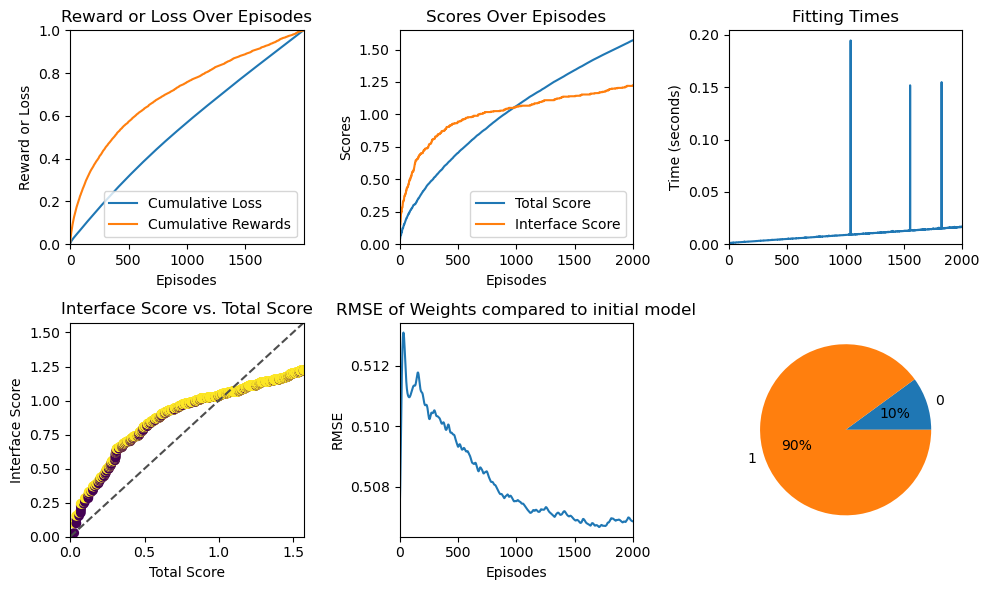

0.8995


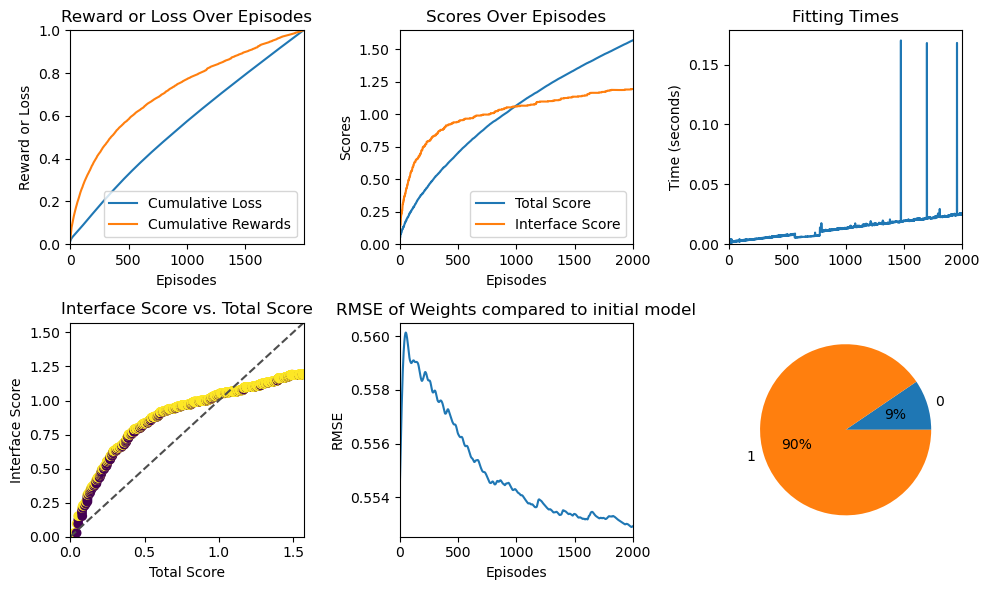

0.905


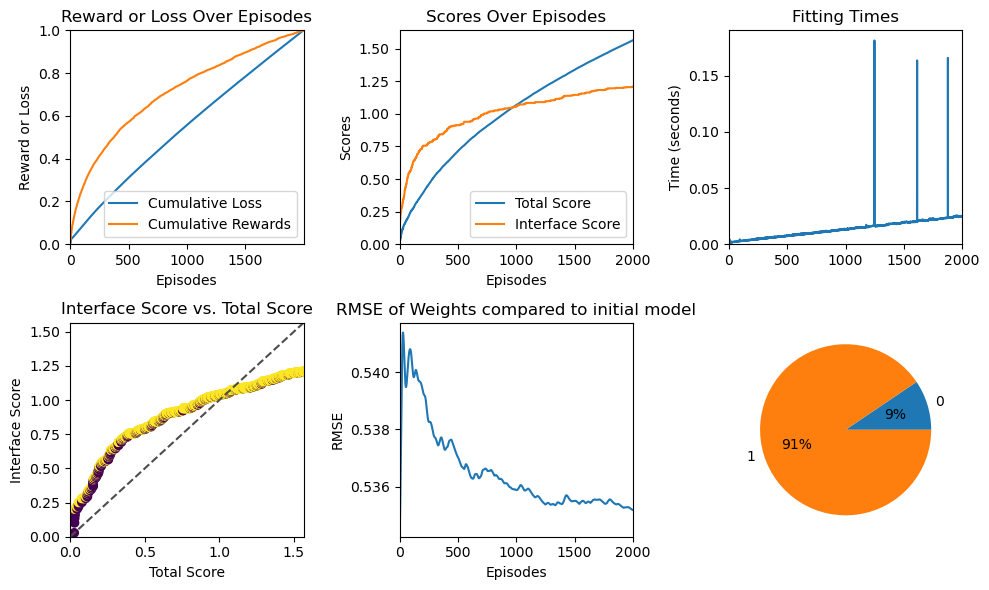

0.9055


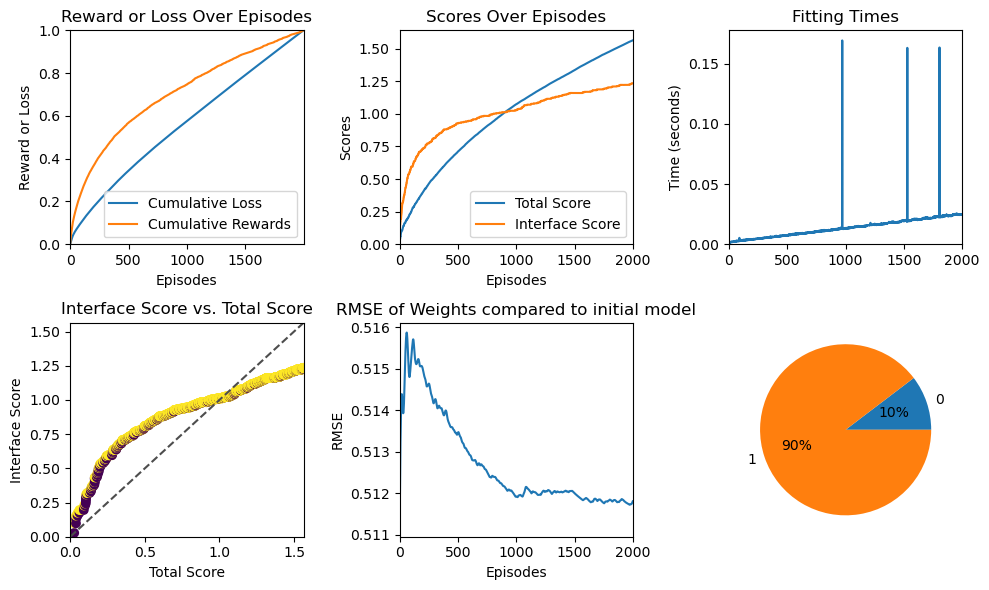

0.8965


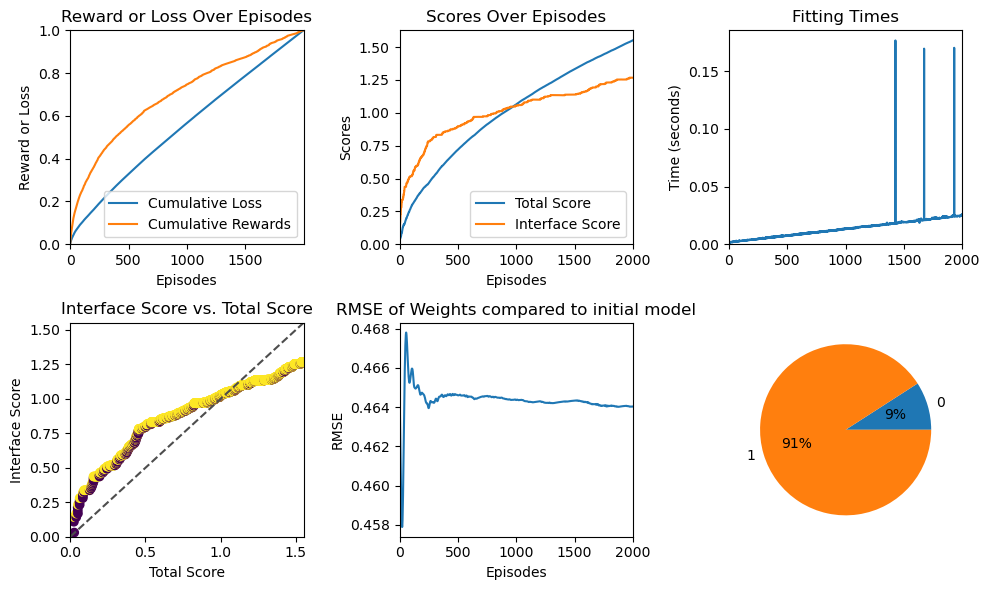

0.909


In [19]:
for i in range(5):
    
    # Create the environment and agent
    env = AIzyme_simulator()
    state, n_actions, n_features = env.reset()
    agent = NeuralBanditAgent(n_actions, n_features, hidden_size=3, lr=0.01, epsilon_decay=0.995)

    models = []
    model_snapshot = copy.deepcopy([param.data.numpy() for param in agent.model.parameters()])
    models = [model_snapshot]
    
    agent.load_weights_biases()
    
    # Access and print the initial weights and biases
    if False:
        print("Initial weights and biases of fc1:")
        print("Weights:", agent.model.fc1.weight.data)
        print("Biases:", agent.model.fc1.bias.data)

        print("\nInitial weights and biases of fc2:")
        print("Weights:", agent.model.fc2.weight.data)
        print("Biases:", agent.model.fc2.bias.data)

    for episode in range(2000):
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action, state)
        agent.update_model(action, state, reward, episode)
        state = next_state     
                 
    model_snapshot = copy.deepcopy([param.data.numpy() for param in agent.model.parameters()])
    models.append(model_snapshot)
        
    agent.save_weights_biases()
    
    agent.plot()
    
    print(float(sum(agent.actions_taken))/len(agent.actions_taken))

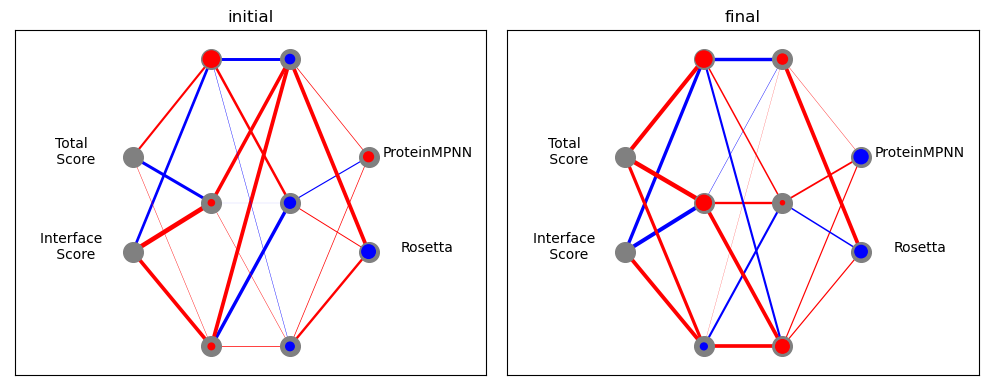

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_network_weights(layers, ax):
    
    weights_input    = layers[0]
    biases_hidden_1  = layers[1]
    weights_hidden_1 = layers[2]
    biases_hidden_2  = layers[3]
    weights_hidden_2 = layers[4]
    biases_output    = layers[5]
    
    n_input    = len(weights_input[0])
    n_hidden_1 = len(biases_hidden_1)
    n_hidden_2 = len(biases_hidden_2)
    n_output   = len(biases_output)
    
    x_input    = [0]*n_input
    y_input    = [0.33,0.66]
    
    x_hidden_1 = [1]*n_hidden_1
    y_hidden_1 = np.linspace(0, 1, n_hidden_1)
    
    x_hidden_2 = [2]*n_hidden_2
    y_hidden_2 = np.linspace(0, 1, n_hidden_2)
    
    x_output   = [3]*n_output
    y_output   = [0.33,0.66]
    
    scale_factor = 200
    neuron_size_hidden_1 = np.abs(biases_hidden_1) * scale_factor
    neuron_size_hidden_2 = np.abs(biases_hidden_2) * scale_factor
    neuron_size_output   = np.abs(biases_output) * scale_factor
    
    c= 'grey'
    
    for j in range(n_input):
        for k in range(n_hidden_1):
            weight = weights_input[k, j]
            color = 'b' if weight > 0 else 'r'
            ax.plot([0, 1], [y_input[j], y_hidden_1[k]], color=color, linewidth=abs(weight * 5), zorder=1)
            
    for j in range(n_hidden_1):
        for k in range(n_hidden_2):
            weight = weights_hidden_1[k, j]
            color = 'b' if weight > 0 else 'r'
            ax.plot([1, 2], [y_hidden_1[j], y_hidden_2[k]], color=color, linewidth=abs(weight * 5), zorder=1)
                        
    for j in range(n_hidden_2):
        for k in range(n_output):
            weight = weights_hidden_2[k, j]
            color = 'b' if weight > 0 else 'r'
            ax.plot([2, 3], [y_hidden_2[j], y_output[k]], color=color, linewidth=abs(weight * 5), zorder=1)

    ax.scatter(x_input, y_input, s=scale_factor, color=c, zorder=3)
    
    hidden_neuron_colors_1 = ['b' if bias > 0 else 'r' for bias in biases_hidden_1]
    ax.scatter(x_hidden_1, y_hidden_1, s=scale_factor, color=c, linewidth=1, zorder=2)
    ax.scatter(x_hidden_1, y_hidden_1, s=neuron_size_hidden_1, color=hidden_neuron_colors_1, zorder=3)
        
    hidden_neuron_colors_2 = ['b' if bias > 0 else 'r' for bias in biases_hidden_2]
    ax.scatter(x_hidden_2, y_hidden_2, s=scale_factor, color=c, linewidth=1, zorder=2)
    ax.scatter(x_hidden_2, y_hidden_2, s=neuron_size_hidden_2, color=hidden_neuron_colors_2, zorder=3)
    
    output_neuron_color = ['b' if bias > 0 else 'r' for bias in biases_output]
    ax.scatter(x_output, y_output, s=scale_factor, color=c, edgecolor=c, linewidth=1, zorder=2)
    ax.scatter(x_output, y_output, s=neuron_size_output, color=output_neuron_color, zorder=3)
    
    for i, y in enumerate(["Interface","Total"]):
        ax.text(-0.75, y_input[i]-0.025, f'{y} \n Score', horizontalalignment='center')
    for i, y in enumerate(["Rosetta","ProteinMPNN"]):
        ax.text(3.75, y_output[i], f'{y}', horizontalalignment='center')
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.5, 4.5)
    ax.set_ylim(-0.1, 1.1)

fig, axs = plt.subplots(1, len(models), figsize=(10, 4))
for i, model in enumerate(models):
    plot_network_weights(model, axs[i])
    if i == 0: title = "initial"
    if i == 1: title = "final"
    axs[i].set_title(title)
plt.tight_layout()
plt.show()